# The entire thing can be run in the background by running the next cell, or it can be stepped through gradually by running each cell consecutively.

In [1]:
%run SyphilisModel

Beginning experiment
Plotting effects of intervention
Plotting screening interval that leads to eradication


<Figure size 720x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
#Initial population values. Each class begins with one case of primary syphilis
E = 0 #exposed
YP = 1 #primary syph
YS = 0 #secondary syph
L = 0 # late latent syph
EL = 0 #early laten syph
YRS = 0 #recurrent secondary syph
Z = 0 #partial immunity (temporary)
Yt = 0 #tertiary syph

#Activity class values
Ntot = 100000 #total population size

#Size of population for classes 1, 2, and 3
nClasses = 3
N1 = 0.72*Ntot     
N2 = 0.15*Ntot         
N3 = 0.13*Ntot 

#Number of partnerships for classes 1, 2, and 3
C1 = 2 
C2 = 8
C3 = 30
totC = (N1*C1)+(N2*C2)+(N3*C3) #total partnerships

#make a list of lists of parameters for each sexual activity class
class1 = [(N1*C1/totC), N1, C1]
class2 = [(N2*C2/totC), N2, C2]
class3 = [(N3*C3/totC), N3, C3]
sexclass = [class1, class2, class3] 

#initial compartment values for each class in a list
init1 = [N1-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 1
init2 = [N2-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 2
init3 = [N3-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 3
init = init1 + init2 + init3 #make a single list containing all values
             
#parameters
sig1 = 1/21 #Average incubation period, days, E -> YP
sig2 = 1/46 #Average time, days, spent YP -> YS
sig3 = 1/108 #Average time, days, spent YS -> L and YS -> EL and YRS -> L
sig4 = 0.5 # Rate per year EL -> YRS 
sig5 = 0.033 #Rate per year L -> Yt
gamma = 0.2 #Average rate of loss of immunity following treatment
nu = 0.25 #Proportion of individuals in 2° stage who progress to early latent stage	
beta = 0.003042 #calibrated value
m = 0.033 #Entry/exit rate
tau = 0 #Average treatment rate

#state values at equilibrium
eqVals = [7.19929266e+04, 2.89539121e+00, 2.51877895e+00, 1.29571756e+00,
       1.45674674e-01, 5.62962964e-03, 6.65781880e-02, 0.00000000e+00,
       1.45674624e-01, 1.49941072e+04, 2.41211510e+00, 2.09836401e+00,
       1.07944649e+00, 1.21359806e-01, 4.69057341e-03, 5.54648672e-02,
       0.00000000e+00, 1.21359751e-01, 1.29808691e+04, 7.83091396e+00,
       6.81232338e+00, 3.50441511e+00, 3.93993556e-01, 1.52198669e-02,
       1.80074481e-01, 0.00000000e+00, 3.93993552e-01]

dt = 0.002 #step size

In [155]:
def transmission(time, dt, current_state, sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu):
    '''
    Compartmental model using Euler
    Input:
    time: duration
    dt: step size
    current_state: flat list containing current population values for all classes
    sexclass: list of lists, with each list containing parameters for one behaviour class
    constant model parameters: beta:nu
    
    Output:
    current_state: flat list containing updated values of current_state
    inf: list of incidence at each time step 

    '''
    steps = int(time/dt)
    substeps = int(steps/time)
    slices = np.linspace(0, len(current_state), len(sexclass)+1) #get indices of current_state corresponding to each class. len(sexclass) is number of classes. +1 to give endpoint
    inf = []
    for i in range(time):
        inf.append(current_state[2]+current_state[11]+current_state[20])
        for _ in range(substeps):
            lambdas = get_lambda(current_state, sexclass, beta) #Get lambda value for all activity classes
            nStep = [] #Initialize vector to be returned with the next set of values
            for i in range(len(sexclass)): # Do the step for each sex activity class
                X, E, YP, YS, L, EL, YRS, Z, Yt = current_state[int(slices[i]):int(slices[i+1])] #Unpack the values of current_state for each class
                lam = lambdas[i]
                N = sexclass[i][1]
                fX = X + (m*N + tau*YP + tau*YS + gamma*Z - (lam+m)*X)*dt
                fE =  E + (lam*X-(sig1+m)*E)*dt
                fYP = YP + (sig1*E -(m+tau+sig2)*YP)*dt
                fYS = YS + (sig2*YP - (m+tau+sig3)*YS)*dt
                fEL =  EL + (nu*sig3*YS - (m + tau + sig4)*EL)*dt
                fYRS = YRS + (sig4*EL - (m + tau + sig3)*YRS)*dt
                fL = L + (sig3*YRS + (1 - nu)*sig3*YS - (sig5 + m + tau)*L)*dt
                fYt = Yt + (sig5*L - (m + tau)*Yt)*dt
                fZ = Z + (tau*L + tau*Yt + tau*YRS + tau*EL - (gamma + m)*Z)*dt
                nStep += [fX, fE, fYP, fYS, fL, fEL, fYRS, fZ, fYt]
            current_state = nStep
    return current_state, inf




In [12]:
def get_lambda(current_state, sexclass, beta):    
    '''
    Calculate the lambda for each sexual activity class. Called by transmission()
    Input:
    current state: list of current state for each behaviour class
    sexclass: list of lists containing parameters for each class 
    beta: probability of transmission per partnership
    
    Output:
    list of force of infection for each class
    '''
    propInf = 0
    slices = np.linspace(0, len(current_state), len(sexclass)+1) #get indices of current_state corresponding to each class. len(sexclass) is number of classes. +1 to give endpoint
    cList = []
    for i in range(len(sexclass)): #for each class
        prop, N, C = sexclass[i] #unpack class parameters
        X, E, YP, YS, L, EL, YRS, Z, Yt = current_state[int(slices[i]):int(slices[i+1])] #unpack class state
        yInf = (YP+YS+YRS)/N #get class contribution to lambda
        classProp = prop*yInf
        cList.append(C) #Store the partner value in a list so the entire list doesn't have to be unpacked twice
        propInf += classProp  
    lamList = []
    for C in cList:
        lam = C*beta*propInf
        lamList.append(lam) 
    return lamList

# Find value of tau that leads to eradication in 20 years

In [128]:
time = 20

taus = np.linspace(1,12,100) #get 250 values for tau between 1 and 12
inf20 = [] #make an empty list which will have the value at time 20 for each tau

#test each value
for tau in taus:
    endstate, inf = transmission(time, dt, current_state, sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu)
    inf20.append(inf[-1])

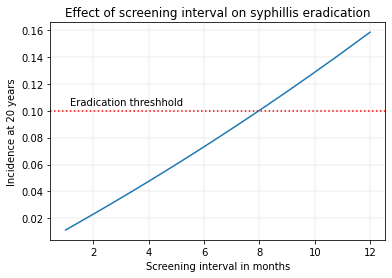

In [134]:
tInt = [12/i for i in taus] #convert tau to screening intervals
plt.plot(tInt, inf20)
plt.grid(linewidth=0.2)
plt.ylabel('Incidence at 20 years')
plt.xlabel('Screening interval in months')
plt.axhline(y = 0.1, color = 'r', linestyle = ':')
plt.annotate('Eradication threshhold', xy=(1.15, 0.104), xytext=(1.15, 0.104))
plt.title('Effect of screening interval on syphilis eradication')


# The impact of screening after 10 years

Text(0.5, 1.0, 'Syphillis incidence with and without intervention')

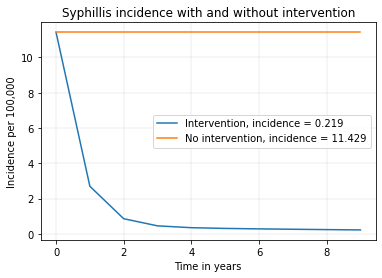

In [171]:
time = 10
Years = list(range(time)) #Make a list of years for X axis

#Unscreened population
tau = 0
resultUn, infUn = transmission(time, dt, eqVals, sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu)

#Screened population
tau = 1.51
resultTr, infTr = transmission(time, dt, eqVals, sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu)

plt.plot(Years, infTr, label='Intervention, incidence = %1.3f' %infTr[-1])
plt.plot(Years, infUn, label='No intervention, incidence = %1.3f' %infUn[-1])
plt.grid(linewidth=0.2)
plt.legend()
plt.ylabel('Incidence per 100,000')
plt.xlabel('Time in years')
plt.title('Syphilis incidence with and without intervention')

Text(0.5, 1.0, 'Relative incidence of syphilis following intervention = 1.912')

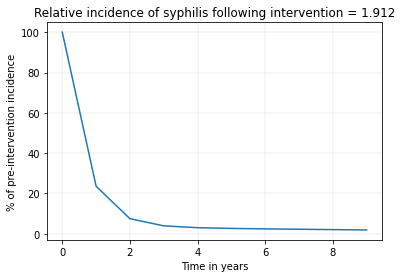

In [172]:
#get relative rate
relInc = 100/infUn[-1] #get incidence of untreated population
relInf = [i*relInc for i in infTr] #transform incidence rate 

plt.plot(Years, relInf)
plt.grid(linewidth=0.2)
plt.ylabel('% of pre-intervention incidence')
plt.xlabel('Time in years')
plt.title('Relative incidence of syphilis following intervention = %1.3f' %relInf[-1])